In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import time
from numba import jit 

In [2]:
def xy_2_idx(x, y, Lx, Ly):
    return x*Ly + y

def idx_2_xy(idx, Lx, Ly):
    return idx//Ly, idx%Ly

def get_bond_indices(Lx, Ly):
    N = Lx * Ly
    ver_bond_list = []
    hor_bond_list = []
    for idx in range(N):
        x, y = idx_2_xy(idx, Lx, Ly)
        hor_idx = xy_2_idx((x+1)%Lx, y, Lx, Ly) # bond (x+1, y) (periodic boundaries)
        ver_idx = xy_2_idx(x, (y+1)%Ly, Lx, Ly) # bond (x, y+1) 
        hor_bond_list.append([idx, hor_idx])
        ver_bond_list.append([idx, ver_idx])


    bond_list = hor_bond_list + ver_bond_list
    bond_indices = np.array(bond_list)
    return bond_indices

(b) 1D array for spin states

In [3]:
def init_system(Lx, Ly):
    N = Lx * Ly
    spin_config = (2*(np.random.randint(0,2, size=[N])-0.5)).astype(int) # array with spin states (+1 or -1 randomly)
    bond_indices = get_bond_indices(Lx, Ly)
    return spin_config, bond_indices, N

In [4]:
### debug checking
Lx = Ly = 16
N = Lx * Ly
spin_config, bond_indices, N = init_system(Lx, Ly)
print(bond_indices)

[[  0  16]
 [  1  17]
 [  2  18]
 ...
 [253 254]
 [254 255]
 [255 240]]


(c) determine the bond_config wb for each of the bonds

In [7]:
# part c)
### Implementation (i) : with jit
@jit(nopython=True)
def get_bond_config(spin_config, bond_indices, T):
    bond_config = np.zeros(len(bond_indices))
    p = np.exp(-2./T)  # set J = 1, k_B = 1
    for b in range(len(bond_indices)):
        n = bond_indices[b, 0]
        m = bond_indices[b, 1]
        #if spin_config[n] != spin_config[m]:
        #    bond_config[b] = 0.
        #else:
        #    if np.random.rand() < p:
        #        bond_config[b] = 0.
        #    else: 
        #        bond_config[b] = 1.
        if spin_config[n] == spin_config[m] and np.random.rand() > p:
            bond_config[b] = 1.
        else:
            pass
            
    return bond_config 

### Implementation (ii) : with pure numpy
def get_bond_config(spin_config, bond_indices, T):
    '''
    get the bond_config wb for each of the bonds
    '''
    beta = 1./T
    N = np.size(spin_config)

    ZZ = spin_config[bond_indices[:,0]] * spin_config[bond_indices[:,1]] # +1 if aligned, -1 otherwise
    bond_config = np.zeros([2*N])
    rand_array = np.array(np.random.rand(2*N) > np.exp(-2.*beta)).astype(int)
    bond_config[ZZ == 1] = rand_array[ZZ == 1]
    return bond_config

bond_config = get_bond_config(spin_config, bond_indices, T=1.0)

In [6]:
# (d) determine the connected components

# part d)
### Implementation (i) : with jit
@jit(nopython=True)
def flip_spin_config(spin_config, N_components, labels):
    flip_cluster = np.random.random(N_components) < 0.5   # N_components True/False values with 50/50 chance
    for n in range(len(spin_config)):
        cluster = labels[n]
        if flip_cluster[cluster]:
            spin_config[n] = - spin_config[n]
    # done 

def swendsen_wang_update(spin_config, bond_indices, T):
    """
    [modification inplace]
    Perform one update of the Swendsen-Wang algorithm
    """
    N = len(spin_config)
    bond_config = get_bond_config(spin_config, bond_indices, T)
    graph = csr_matrix((bond_config, (bond_indices[:, 0], bond_indices[:, 1])), shape=(N, N))
    # graph += csr_matrix((bond_config, (bond_indices[:, 1], bond_indices[:, 0])), shape=(N, N))
    graph = graph + graph.T
    N_components, labels = connected_components(graph, directed=False)
    flip_spin_config(spin_config, N_components, labels)
    return spin_config ## This is not necessary since we modify in-place



### Implementation (ii) : with pure numpy
def swendsen_wang_update(spin_config, bond_indices, T):
    """
    Perform one update of the Swendsen-Wang algorithm
    """
    N = np.size(spin_config)
    bond_config = get_bond_config(spin_config, bond_indices, T=T)
    graph = csr_matrix((bond_config, (bond_indices[:, 0], bond_indices[:, 1])), shape=(N, N))
    graph = graph + graph.T
    n_components, labels = scipy.sparse.csgraph.connected_components(graph)
    cluster_flip_or_not = np.random.randint(0, 2, size=[n_components])
    site_flip_or_not = (-1) ** cluster_flip_or_not[labels]
    newconfig = spin_config * site_flip_or_not
    return newconfig

In [7]:
%%timeit
swendsen_wang_update(spin_config, bond_indices, 1.)

740 µs ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


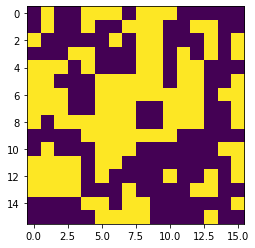

In [8]:
spin_config = swendsen_wang_update(spin_config, bond_indices, T=3.)
plt.imshow(spin_config.reshape(Lx, Ly))

In [9]:
def energy(spin_config, bond_indices):
    """alternative implementation, gives the same results, but does not require jit to be fast"""
    return -1. * np.sum(spin_config[bond_indices[:, 0]]* spin_config[bond_indices[:, 1]])

@jit(nopython=True)
def energy(spin_config, bond_indices):
    Nbonds = len(bond_indices)
    energy = 0.
    for b in range(Nbonds):
        energy -= spin_config[bond_indices[b, 0]]* spin_config[bond_indices[b, 1]]
    return energy

def magnetization(spin_config):
    return np.sum(spin_config)

In [10]:
def simulation(spin_config, bond_indices, T, N_measure=100):
    """Perform a Monte-carlo simulation at given temperature"""
    # thermalization: without measurement
    for _ in range(N_measure//10):
        spin_config = swendsen_wang_update(spin_config, bond_indices, T)
        
    Es = []
    Ms = []
    for n in range(N_measure):
        spin_config = swendsen_wang_update(spin_config, bond_indices, T)
        Es.append(energy(spin_config, bond_indices))
        Ms.append(magnetization(spin_config))
        
    return np.array(Es), np.array(Ms)

In [11]:
# The full simulation at different temperatures
def run(Ts, L, N_measure=100):
    spin_config, bond_indices, N = init_system(L, L)
    spin_config = np.random.randint(0, 2, size=(N,))*2 - 1
    Ms = []
    absMs = []
    Es = []
    Cs = []
    for T in Ts:
        #print("simulating T = ", T, flush=True)
        E, M = simulation(spin_config, bond_indices, T, N_measure)
        Es.append(np.mean(E)/N)
        Cs.append(np.var(E)/(T**2*N))
        Ms.append(np.mean(M)/N)
        absMs.append(np.mean(np.abs(M))/N)
        
    return Es, Cs, Ms, absMs 

calculate L = 4
   took 29.1 seconds
calculate L = 8
   took 31.2 seconds
calculate L = 16
   took 31.9 seconds
calculate L = 32
   took 35.8 seconds
done


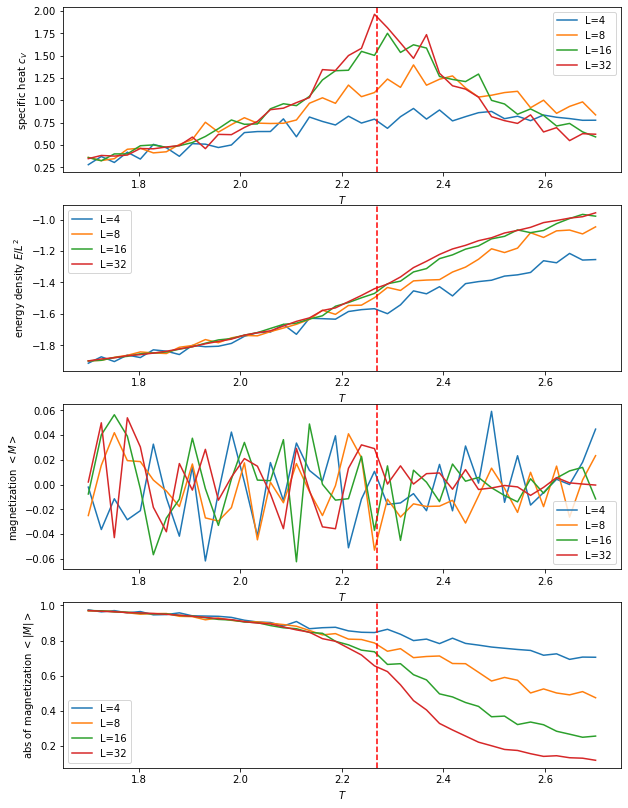

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(10, 14))
ax1, ax2, ax3, ax4 = axes
Tc = 2. / np.log(1. + np.sqrt(2))
Ts = np.linspace(2.7, 1.7, 40)

print("warning: this takes some time")
for L in [4, 8, 16, 32]:
    print("calculate L =", L, flush=True)
    t0 = time.time()
    Es, Cs, Ms, absMs = run(Ts, L, N_measure=1000)
    # Plot the results
    ax1.plot(Ts, Cs, label='L={L:d}'.format(L=L))
    ax2.plot(Ts, Es, label='L={L:d}'.format(L=L))
    ax3.plot(Ts, Ms, label='L={L:d}'.format(L=L))
    ax4.plot(Ts, absMs, label='L={L:d}'.format(L=L))
    print("   took {t:.1f} seconds".format(t=time.time()-t0), flush=True)


for ax in axes:
    ax.axvline(Tc, color='r', linestyle='--')
    ax.set_xlabel('$T$')
    ax.legend(loc='best')

ax1.set_ylabel('specific heat $c_V$')
ax2.set_ylabel('energy density $E/L^2$')
ax3.set_ylabel('magnetization $<M>$')
ax4.set_ylabel('abs of magnetization $<|M|>$')
print("done")

# Auto-correlation time
$         C_E(\delta) = \frac{<{E_{t+\delta} E_t}>_t - <{E_t}>_t^2}{<{(E_t)^2}>_t - <{E_t}>_t^2} $

$         C_E(\delta) = \frac{<({E_{t+\delta}-<{E_t}>_t)(E_t-< E_t>_t)>_t }}{<{(E_t)^2}>_t - <{E_t}>_t^2} \approx \frac{<({E_{t+\delta}-<{E_{t+\delta}}>_t)(E_t-< E_t>_t)>_t }}{<{(E_t)^2}>_t - <{E_t}>_t^2}$

In [13]:
def auto_correlation(E, delta):
    if delta == 0:
        return 1.

    N = len(E)
    dE = E - np.mean(E)
    cor = np.mean(dE[delta:] * dE[:-delta]) / np.mean(dE**2)
    return cor 

### Auto-correlation time of Swendsen-Wang algorithm

T= 2.0
T= 2.269185314213022


/tmp/ipykernel_68945/2798531953.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))


T= 3.0


/tmp/ipykernel_68945/2798531953.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))
/tmp/ipykernel_68945/2798531953.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))


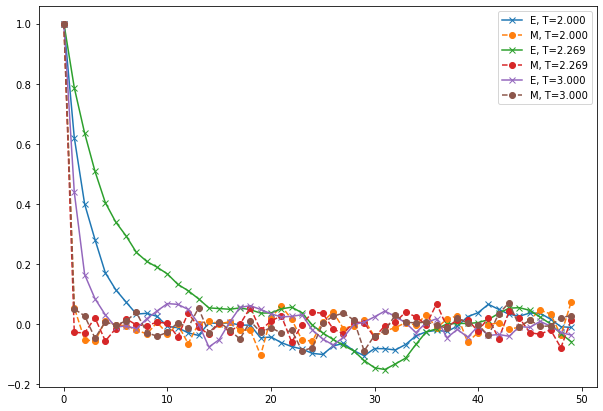

In [14]:
L = 64
spins, bonds, N = init_system(L, L)
deltas = np.arange(0, 50)

plt.figure(figsize=(10, 7))
for T in [2., Tc, 3.]:
    print("T=", T, flush=True)
    E, M = simulation(spins, bonds, T, 1000)
    cor_E = [auto_correlation(E, d) for d in deltas]
    cor_M = [auto_correlation(M, d) for d in deltas]
    plt.plot(deltas, cor_E, 'x-', label="E, T={T:.3f}".format(T=T))
    plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))
plt.legend()
plt.show()

### Auto correlation of Metropolis algorithm


In [15]:
def bonds_alternative(Lx, Ly):
    N = Lx * Ly

    def xy_to_n(x, y):
        return x*Ly + y

    bonds_alt = []
    for x in range(Lx):
        for y in range(Ly):
            n = xy_to_n(x, y)
            m1 = xy_to_n((x+1)% Lx, y)
            m2 = xy_to_n(x, (y+1) % Ly)
            m3 = xy_to_n((x-1)% Lx, y)
            m4 = xy_to_n(x, (y-1) % Ly)
            bonds_alt.append([m1, m2, m3, m4])
    return np.array(bonds_alt)

@jit(nopython=True)
def delta_E(spins, bonds_alt, n):
    z = bonds_alt.shape[1]
    s = 0.
    for i in range(z):
        s += spins[bonds_alt[n, i]]
    return -spins[n] * s

@jit(nopython=True)
def energy(spin_config, bond_indices):
    Nbonds = len(bond_indices)
    energy = 0.
    for b in range(Nbonds):
        energy -= spin_config[bond_indices[b, 0]]* spin_config[bond_indices[b, 1]]
    return energy

@jit(nopython=True)
def metropolis_update(spins, bonds, bonds_alt, T):
    N = len(spins)
    E = energy(spins, bonds)
    for _ in range(N):
        n = np.random.randint(0, N)
        dE = -2. * delta_E(spins, bonds_alt, n)
        if np.random.rand() < np.exp(-dE/T):
            spins[n] *= -1
            E += dE
    # done

def simulation_metropolis(spins, bonds, bonds_alt, T, N_measure=100):
    """Perform a Monte-carlo simulation at given temperature"""
    # thermalization: without measurement
    for _ in range(N_measure//10):
        metropolis_update(spins, bonds, bonds_alt, T)
    Es = []
    Ms = []
    for n in range(N_measure):
        metropolis_update(spins, bonds, bonds_alt, T)
        Es.append(energy(spins, bonds))
        Ms.append(magnetization(spins))
    return np.array(Es), np.array(Ms)

T= 2.0
T= 2.269185314213022
T= 3.0


/tmp/ipykernel_68945/3848379064.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))
/tmp/ipykernel_68945/3848379064.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))
/tmp/ipykernel_68945/3848379064.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))


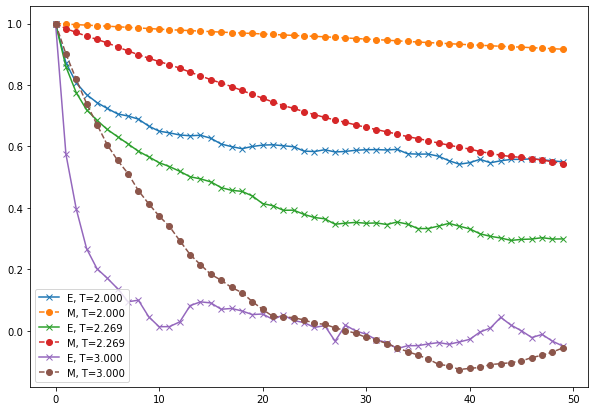

In [16]:
spins, bonds, N = init_system(L, L)
bonds_alt = bonds_alternative(L, L)

plt.figure(figsize=(10, 7))
for T in [2., Tc, 3.]:
    print("T=", T, flush=True)
    E, M = simulation_metropolis(spins, bonds, bonds_alt, T, 1000)
    cor_E = [auto_correlation(E, d) for d in deltas]
    cor_M = [auto_correlation(M, d) for d in deltas]
    plt.plot(deltas, cor_E, 'x-', label="E, T={T:.3f}".format(T=T))
    plt.plot(deltas, cor_M, 'o-', linestyle='--', label="M, T={T:.3f}".format(T=T))
plt.legend()
plt.show()

### Miscellaneous: checks for debugging


In [17]:
L = 64
spins, bonds, N = init_system(L, L) 

E, M = simulation(spins, bonds, 2., N_measure=10)
print(M)
print(E) 

T = 0.1
print(spins)
for i in range(100):
    swendsen_wang_update(spins, bonds, T)
print(spins)
print(energy(spins, bonds))
# assert(energy(spins, bonds) == energy2(spins, bonds))
print(magnetization(spins)) 

[ -378  -290  -588  -680 -3530  3588 -3586  3658  3738  3744]
[-4368. -5180. -5852. -6088. -6576. -6784. -6864. -6912. -7100. -7088.]
[-1  1  1 ...  1 -1 -1]
[-1  1  1 ...  1 -1 -1]
124.0
-110


### Miscellaneous: Inplace modification
Notice function i(x) does not modify numpy array x inplace.

In [18]:
a = np.ones(4)

def f(x):
    x[0] = x[0] + 1    

def g(x):
    x[1] += 1
    
def h(x):
    x += 1
    
def i(x):
    x = x + 1
    

print(a)
f(a)
print("after f: ", a)
g(a)
print("after g: ", a)
h(a)
print("after h: ", a)
i(a)
print("after i: ", a) 

[1. 1. 1. 1.]
after f:  [2. 1. 1. 1.]
after g:  [2. 2. 1. 1.]
after h:  [3. 3. 2. 2.]
after i:  [3. 3. 2. 2.]
